In [1]:
import os
import numpy as np
from scipy.fftpack import dct
from scipy.signal import cwt
from pywt import dwt2
from skimage.io import imread, imshow
from skimage.measure import shannon_entropy
import matplotlib.pyplot as plt
from IPython import display

from utils import (
    SoftThresh,
    ShrinkageOperator,
    Proj
)

%matplotlib inline

## Import an image to compress and reconstruct

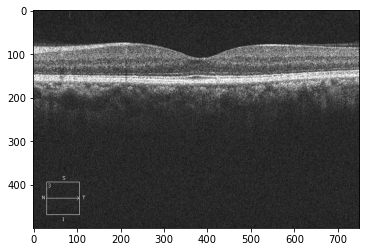

In [111]:
image_path = "OCTID_NORMAL"
image_name = "NORMAL10.jpeg"
image = os.path.join(image_path, image_name)

oct_image = imread(image)
plt.imshow(oct_image, cmap='gray')

# Taking the first of the 3 channels, as they are all the same.
X = oct_image[:,:,0]
compression_factor = 2
compression_factor_ = 3
h, w = X.shape
mask = np.random.binomial(size=(h, w), n=1, p=1/compression_factor)
mask_3 = np.random.binomial(size=(h, w), n=1, p=1/compression_factor_)
plt.imshow(oct_image, cmap='gray')

In [104]:
h, w = X.shape
mask = np.random.binomial(size=(h, w), n=1, p=1/compression_factor)

basis_ = "dct"

if basis_ == "dct":
    B1 = dct(np.eye(h), norm='ortho', axis=0).T
    B2t = dct(np.eye(w), norm='ortho', axis=0)
else: 
    # pywt.dwt2 is the discrete wavelet transform in 2D. It returns the transformed array
    # in 4 equaly sized block matrices which are simplpy regions of the entire 2D transform
    (cA, (cH, cV, cD)) = dwt2(np.eye(h), 'db1')
    upper = np.concatenate([cA, cH])
    lower = np.concatenate([cV, cD])
    B1 = np.concatenate([upper, lower], axis=1)
    
    (cA, (cH, cV, cD)) = dwt2(np.eye(w), 'db1')
    upper = np.concatenate([cA, cH])
    lower = np.concatenate([cV, cD])
    B2t = np.concatenate([upper, lower], axis=1)

In [40]:
def Update1(mask, B1, B2t, W, D, a):
    # Minimize the error with respect to constraint P_{\Omega}(B1 @ W @ B2t) == P_{\Omega}
    Z = Proj(B1 @ W @ B2t, mask) - D
    Z = B1.T @ Z @ B2t.T
    return W - a*Z

Iteration 1:	Reconstruction Error: 8663.69	Spectral Norm W: 145292.80	Sparisty of W: 146695.14
Resulting Reconstruction after 0 interations:


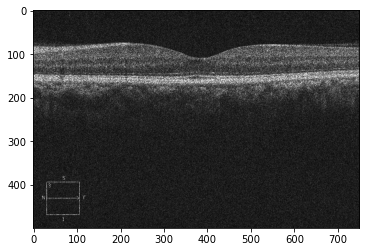

Iteration 51:	Reconstruction Error: 8663.69	Spectral Norm W: 145292.80	Sparisty of W: 146695.14
Iteration 101:	Reconstruction Error: 8663.69	Spectral Norm W: 145292.80	Sparisty of W: 146695.14
Iteration 151:	Reconstruction Error: 8663.69	Spectral Norm W: 145292.80	Sparisty of W: 146695.14
Iteration 201:	Reconstruction Error: 8663.69	Spectral Norm W: 145292.80	Sparisty of W: 146695.14
Iteration 251:	Reconstruction Error: 8663.69	Spectral Norm W: 145292.80	Sparisty of W: 146695.14
Resulting Reconstruction after 250 interations:


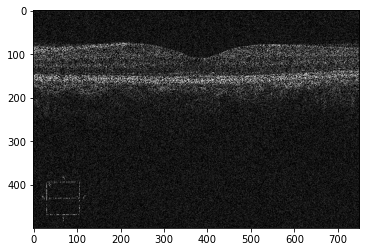

Iteration 301:	Reconstruction Error: 8663.69	Spectral Norm W: 145292.80	Sparisty of W: 146695.14
Iteration 351:	Reconstruction Error: 8663.69	Spectral Norm W: 145292.80	Sparisty of W: 146695.14
Iteration 401:	Reconstruction Error: 8663.69	Spectral Norm W: 145292.80	Sparisty of W: 146695.14
Iteration 451:	Reconstruction Error: 8663.69	Spectral Norm W: 145292.80	Sparisty of W: 146695.14
Iteration 501:	Reconstruction Error: 8663.69	Spectral Norm W: 145292.80	Sparisty of W: 146695.14
Resulting Reconstruction after 500 interations:


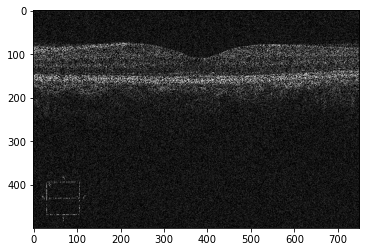

Iteration 551:	Reconstruction Error: 8663.69	Spectral Norm W: 145292.80	Sparisty of W: 146695.14
Iteration 601:	Reconstruction Error: 8663.69	Spectral Norm W: 145292.80	Sparisty of W: 146695.14
Iteration 651:	Reconstruction Error: 8663.69	Spectral Norm W: 145292.80	Sparisty of W: 146695.14
Iteration 701:	Reconstruction Error: 8663.69	Spectral Norm W: 145292.80	Sparisty of W: 146695.14
Iteration 751:	Reconstruction Error: 8663.69	Spectral Norm W: 145292.80	Sparisty of W: 146695.14
Resulting Reconstruction after 750 interations:


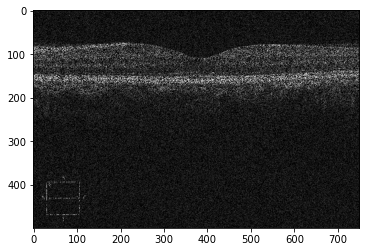

Iteration 801:	Reconstruction Error: 8663.69	Spectral Norm W: 145292.80	Sparisty of W: 146695.14
Iteration 851:	Reconstruction Error: 8663.69	Spectral Norm W: 145292.80	Sparisty of W: 146695.14
Iteration 901:	Reconstruction Error: 8663.69	Spectral Norm W: 145292.80	Sparisty of W: 146695.14
Iteration 951:	Reconstruction Error: 8663.69	Spectral Norm W: 145292.80	Sparisty of W: 146695.14


 Final Reconstruction


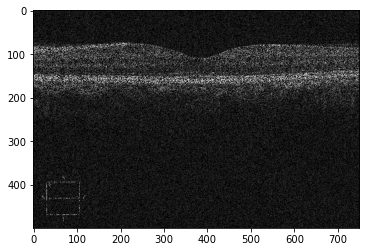

In [86]:
tau_sparse = 1
tau_low_rank = 1
a = 1
D = X
mask_full_obs = np.ones((w, h))
W_full_obs = np.linalg.inv(B1) @ D @ np.linalg.inv(B2t)

reconstruction_error_l1_full_obs = []
spectral_norm_l1_full_obs = []
sparsity_l1_full_obs = []

iters = 1000
for i in range(iters):
    W_full_obs = Update1(mask, B1, B2t, W_full_obs, D, a)

    if i % 2 == 0:
        W_full_obs = ShrinkageOperator(W_full_obs, tau_low_rank)
    else:
        W_full_obs = SoftThresh(W_full_obs, tau_sparse)
    
    spectral_norm_l1_full_obs.append(np.linalg.norm(W_full_obs, ord="nuc"))
    sparsity_l1_full_obs.append(np.linalg.norm(W_full_obs, ord=1))
    reconstruction_error_l1_full_obs.append(np.linalg.norm(X - B1 @ W_full_obs @ B2t))
    if i % 50 == 0:
        print(
            f"Iteration {i+1}:\t"\
            f"Reconstruction Error: {reconstruction_error_l1[-1]:.2f}\t"\
            f"Spectral Norm W: {spectral_norm_l1[-1]:.2f}\t"\
            f"Sparisty of W: {sparsity_l1[-1]:.2f}"
        )
    if i % 250 == 0:
        print(f"Resulting Reconstruction after {i} interations:")
        plt.imshow(B1 @ W_full_obs @ B2t, cmap="gray")
        display.display(plt.gcf())
        
print("\n\n Final Reconstruction")
plt.imshow(B1 @ W_full_obs @ B2t, cmap="gray");

In [ ]:
tau_sparse = 1
tau_low_rank = 1
a = 1
fig, axes = plt.subplots(ncols=3, figsize=(18, 5))

axes[0].plot(reconstruction_error_l1_full_obs, c='b', label=r"Reconstruction Error: $||B_{1} W B_{2}^{\mathbf{T}} - X ||_{2}$")
axes[1].plot(spectral_norm_l1_full_obs, c='r', label=r"Spectral Norm W: $|| W ||_{\ast}$")
axes[2].plot(sparsity_l1_full_obs, c='g', label=r"Sparsity of W: $|| W ||_{1}$")

axes[0].legend()
axes[1].legend()
axes[2].legend()

axes[0].grid(alpha=0.5)
axes[1].grid(alpha=0.5)
axes[2].grid(alpha=0.5)

# fig.suptitle((
#     f"Low Rank + Sparse Reconstruction using {basis_} basis " +
#     r"($\lambda_{Sparse}$ =" + f"{tau_sparse}, " +
#     r"$\lambda_{LowRank}$ =" + f"{tau_low_rank}):"),
#     fontsize=24
# )
fig.set_facecolor('white')
plt.savefig("LowRank_Sparse_Compression_1_plots.png", dpi=400)
plt.show();

plt.figure(figsize=(14, 9));
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(21, 21))
# fig.suptitle(f"Resulting Reconstruction:", fontsize=32)

axes[0][0].set_title(r"Reconstruction: $(B_{1} W_{\lambda} B_{2}^{\mathbf{T}}$)", fontsize=22)
axes[0][0].imshow(B1 @ W_full_obs @ B2t, cmap="gray")

axes[0][1].set_title(r"Compressed: $X$*mask", fontsize=32)
axes[0][1].imshow(X*mask, cmap="gray")

axes[1][0].set_title(r"Original: $X$", fontsize=22)
axes[1][0].imshow(X, cmap="gray")

axes[1][1].set_title(r"$X - (B_{1} W_{\lambda} B_{2}^{\mathbf{T}}$)", fontsize=22)
axes[1][1].imshow(X - (B1 @ W_full_obs @ B2t), cmap="gray")

plt.tight_layout()
fig.set_facecolor('white')
plt.savefig("LowRank_Sparse_Compression_1_grid.png", dpi=400)
plt.show()

Iteration 1:	Reconstruction Error: 31993.90	Spectral Norm W: 420801.76	Sparisty of W: 85740.95
Resulting Reconstruction after 0 interations:


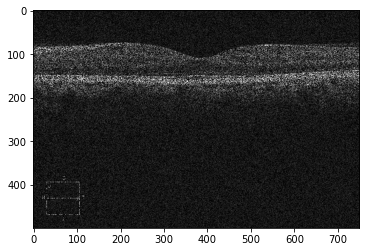

Iteration 51:	Reconstruction Error: 10260.85	Spectral Norm W: 193698.82	Sparisty of W: 133959.52
Iteration 101:	Reconstruction Error: 6844.28	Spectral Norm W: 172919.12	Sparisty of W: 151481.54
Iteration 151:	Reconstruction Error: 6708.46	Spectral Norm W: 172974.39	Sparisty of W: 153537.57
Iteration 201:	Reconstruction Error: 6694.86	Spectral Norm W: 173022.31	Sparisty of W: 153838.76
Iteration 251:	Reconstruction Error: 6692.61	Spectral Norm W: 173031.10	Sparisty of W: 153893.31
Resulting Reconstruction after 250 interations:


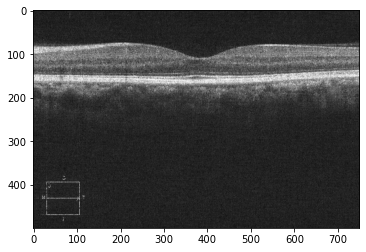

Iteration 301:	Reconstruction Error: 6692.17	Spectral Norm W: 173032.74	Sparisty of W: 153904.18
Iteration 351:	Reconstruction Error: 6692.08	Spectral Norm W: 173033.06	Sparisty of W: 153906.45
Iteration 401:	Reconstruction Error: 6692.07	Spectral Norm W: 173033.13	Sparisty of W: 153906.94
Iteration 451:	Reconstruction Error: 6692.06	Spectral Norm W: 173033.14	Sparisty of W: 153907.05
Iteration 501:	Reconstruction Error: 6692.06	Spectral Norm W: 173033.15	Sparisty of W: 153907.07
Resulting Reconstruction after 500 interations:


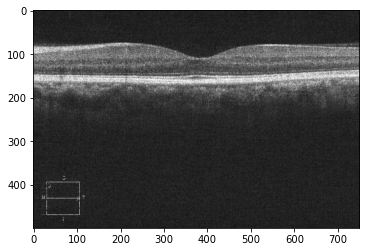

Iteration 551:	Reconstruction Error: 6692.06	Spectral Norm W: 173033.15	Sparisty of W: 153907.08
Iteration 601:	Reconstruction Error: 6692.06	Spectral Norm W: 173033.15	Sparisty of W: 153907.08
Iteration 651:	Reconstruction Error: 6692.06	Spectral Norm W: 173033.15	Sparisty of W: 153907.08
Iteration 701:	Reconstruction Error: 6692.06	Spectral Norm W: 173033.15	Sparisty of W: 153907.08
Iteration 751:	Reconstruction Error: 6692.06	Spectral Norm W: 173033.15	Sparisty of W: 153907.08
Resulting Reconstruction after 750 interations:


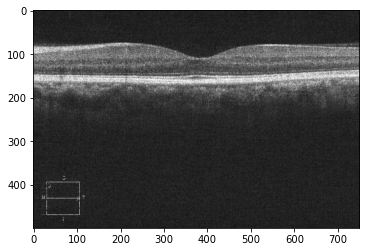

Iteration 801:	Reconstruction Error: 6692.06	Spectral Norm W: 173033.15	Sparisty of W: 153907.08
Iteration 851:	Reconstruction Error: 6692.06	Spectral Norm W: 173033.15	Sparisty of W: 153907.08
Iteration 901:	Reconstruction Error: 6692.06	Spectral Norm W: 173033.15	Sparisty of W: 153907.08
Iteration 951:	Reconstruction Error: 6692.06	Spectral Norm W: 173033.15	Sparisty of W: 153907.08


 Final Reconstruction


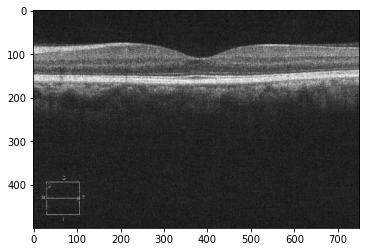

In [81]:
tau_sparse = 3
tau_low_rank = 30
a = 1
D = X*mask
W_c2 = np.linalg.inv(B1) @ D @ np.linalg.inv(B2t)

reconstruction_error_l1 = []
spectral_norm_l1 = []
sparsity_l1 = []

iters = 1000
for i in range(iters):
    W_c2 = Update1(mask, B1, B2t, W_c2, D, a)

    if i % 2 == 0:
        W_c2 = ShrinkageOperator(W_c2, tau_low_rank)
    else:
        W_c2 = SoftThresh(W_c2, tau_sparse)
    
    spectral_norm_l1.append(np.linalg.norm(W_c2, ord="nuc"))
    sparsity_l1.append(np.linalg.norm(W_c2, ord=1))
    reconstruction_error_l1.append(np.linalg.norm(X - B1 @ W_c2 @ B2t))
    if i % 50 == 0:
        print(
            f"Iteration {i+1}:\t"\
            f"Reconstruction Error: {reconstruction_error_l1[-1]:.2f}\t"\
            f"Spectral Norm W: {spectral_norm_l1[-1]:.2f}\t"\
            f"Sparisty of W: {sparsity_l1[-1]:.2f}"
        )
    if i % 250 == 0:
        print(f"Resulting Reconstruction after {i} interations:")
        plt.imshow(B1 @ W_c2 @ B2t, cmap="gray")
        display.display(plt.gcf())
        
print("\n\n Final Reconstruction")
plt.imshow(B1 @ W_c2 @ B2t, cmap="gray");

In [112]:
np.sum(W_c2 == 0) / (w*h)

0.46398666666666666

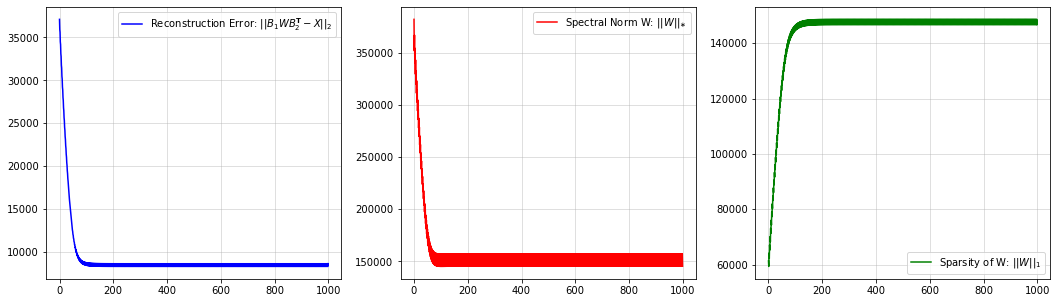

<Figure size 1008x648 with 0 Axes>

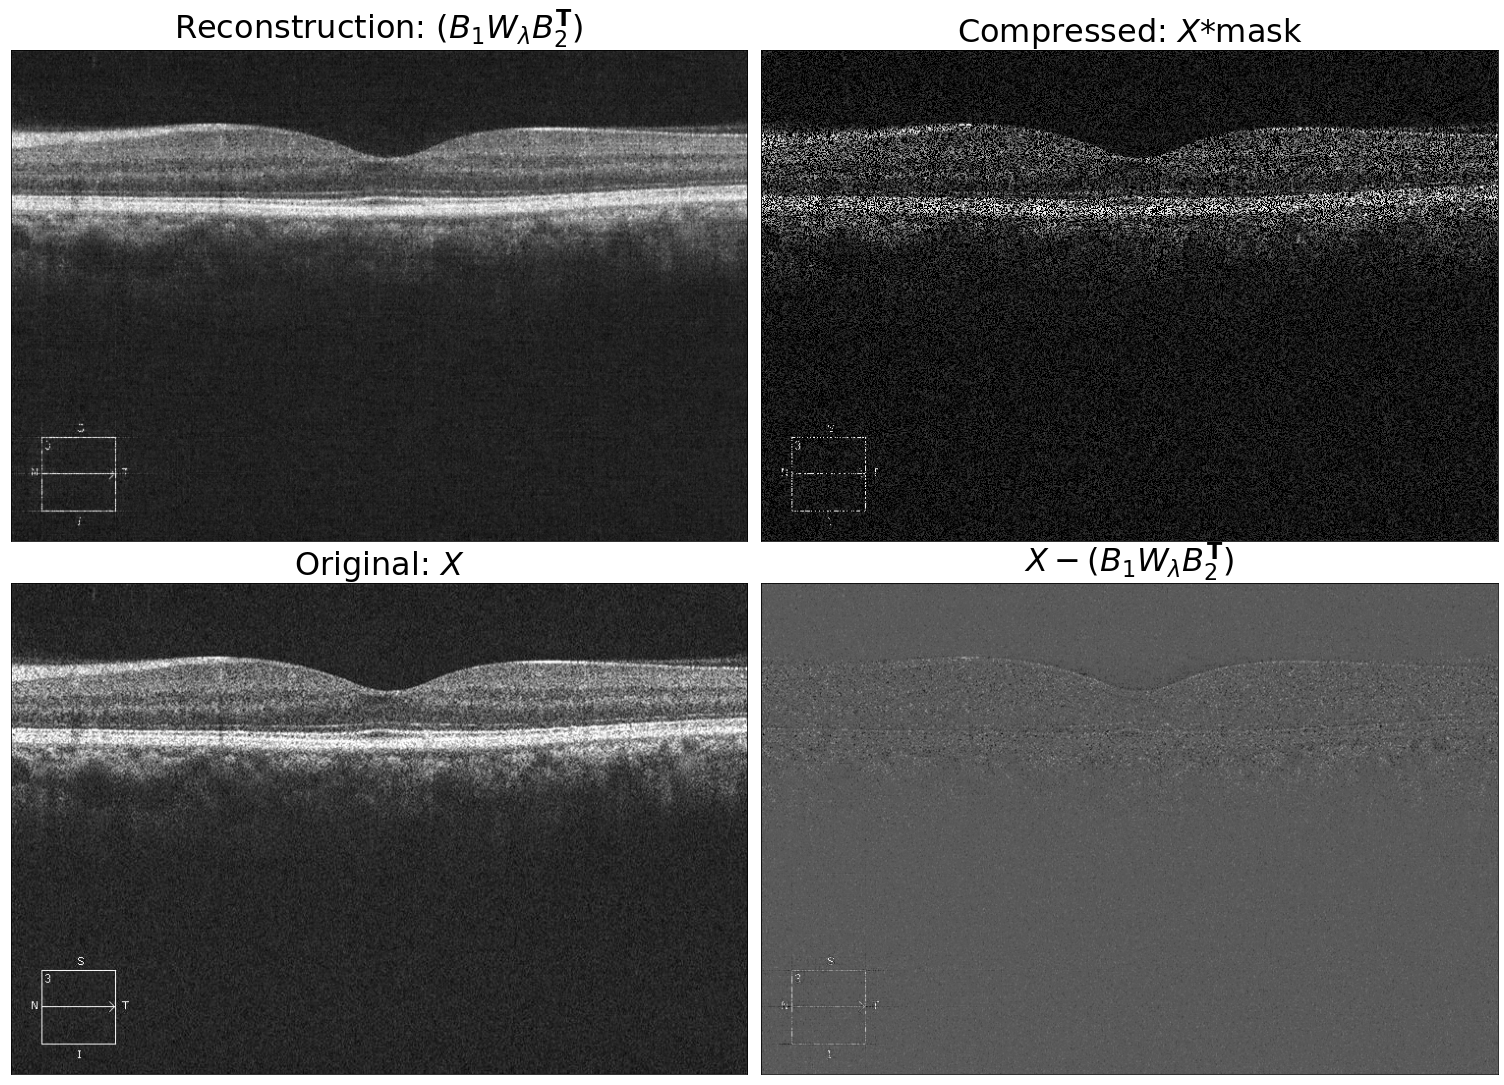

In [105]:
tau_sparse = 3
tau_low_rank = 30
fig, axes = plt.subplots(ncols=3, figsize=(18, 5))

axes[0].plot(reconstruction_error_l1, c='b', label=r"Reconstruction Error: $||B_{1} W B_{2}^{\mathbf{T}} - X ||_{2}$")
axes[1].plot(spectral_norm_l1, c='r', label=r"Spectral Norm W: $|| W ||_{\ast}$")
axes[2].plot(sparsity_l1, c='g', label=r"Sparsity of W: $|| W ||_{1}$")

axes[0].legend()
axes[1].legend()
axes[2].legend()

axes[0].grid(alpha=0.5)
axes[1].grid(alpha=0.5)
axes[2].grid(alpha=0.5)

# fig.suptitle((
#     f"Low Rank + Sparse Reconstruction using {basis_} basis " +
#     r"($\lambda_{Sparse}$ =" + f"{tau_sparse}, " +
#     r"$\lambda_{LowRank}$ =" + f"{tau_low_rank}):"),
#     fontsize=24
# )
fig.set_facecolor('white')
plt.savefig("LowRank_Sparse_Compression_2_plots.png", dpi=400)
plt.show();

plt.figure(figsize=(14, 9));
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(21, 15.5))
# fig.suptitle(f"Resulting Reconstruction:", fontsize=32)

axes[0][0].set_title(r"Reconstruction: $(B_{1} W_{\lambda} B_{2}^{\mathbf{T}}$)", fontsize=32)
axes[0][0].imshow(B1 @ W_c2 @ B2t, cmap="gray")

axes[0][1].set_title(r"Compressed: $X$*mask", fontsize=32)
axes[0][1].imshow(X*mask, cmap="gray")

axes[1][0].set_title(r"Original: $X$", fontsize=32)
axes[1][0].imshow(X, cmap="gray")

axes[1][1].set_title(r"$X - (B_{1} W_{\lambda} B_{2}^{\mathbf{T}}$)", fontsize=32)
axes[1][1].imshow(X - (B1 @ W_c2 @ B2t), cmap="gray")

fig.tight_layout()

for ax in axes:
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    
fig.subplots_adjust(wspace=0.05, hspace=-0.1)

plt.tight_layout()
fig.set_facecolor('white')
plt.savefig("LowRank_Sparse_Compression_2_grid.png", dpi=400)
plt.show()

Iteration 1:	Reconstruction Error: 37095.81	Spectral Norm W: 382450.32	Sparisty of W: 61323.28
Resulting Reconstruction after 0 interations:


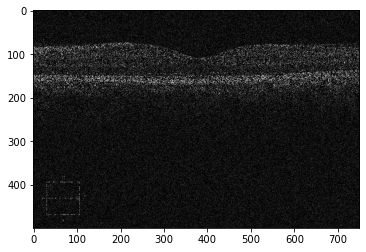

Iteration 51:	Reconstruction Error: 12079.14	Spectral Norm W: 181013.57	Sparisty of W: 126508.43
Iteration 101:	Reconstruction Error: 8465.77	Spectral Norm W: 157068.89	Sparisty of W: 146532.43
Iteration 151:	Reconstruction Error: 8349.74	Spectral Norm W: 157222.40	Sparisty of W: 148357.53
Iteration 201:	Reconstruction Error: 8339.92	Spectral Norm W: 157263.15	Sparisty of W: 148561.75
Iteration 251:	Reconstruction Error: 8338.61	Spectral Norm W: 157268.49	Sparisty of W: 148588.89
Resulting Reconstruction after 250 interations:


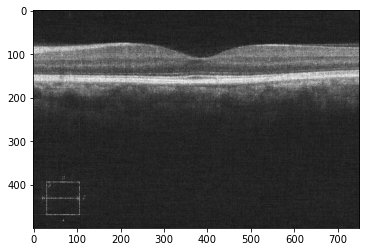

Iteration 301:	Reconstruction Error: 8338.41	Spectral Norm W: 157269.25	Sparisty of W: 148592.82
Iteration 351:	Reconstruction Error: 8338.38	Spectral Norm W: 157269.36	Sparisty of W: 148593.42
Iteration 401:	Reconstruction Error: 8338.38	Spectral Norm W: 157269.38	Sparisty of W: 148593.51
Iteration 451:	Reconstruction Error: 8338.38	Spectral Norm W: 157269.38	Sparisty of W: 148593.53
Iteration 501:	Reconstruction Error: 8338.38	Spectral Norm W: 157269.38	Sparisty of W: 148593.53
Resulting Reconstruction after 500 interations:


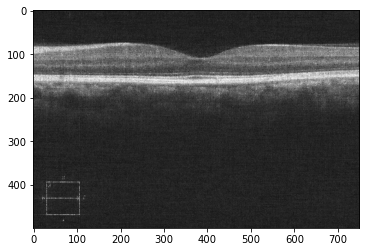

Iteration 551:	Reconstruction Error: 8338.38	Spectral Norm W: 157269.38	Sparisty of W: 148593.53
Iteration 601:	Reconstruction Error: 8338.38	Spectral Norm W: 157269.38	Sparisty of W: 148593.53
Iteration 651:	Reconstruction Error: 8338.38	Spectral Norm W: 157269.38	Sparisty of W: 148593.53
Iteration 701:	Reconstruction Error: 8338.38	Spectral Norm W: 157269.38	Sparisty of W: 148593.53
Iteration 751:	Reconstruction Error: 8338.38	Spectral Norm W: 157269.38	Sparisty of W: 148593.53
Resulting Reconstruction after 750 interations:


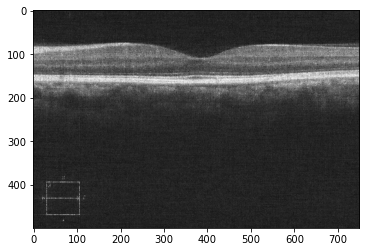

Iteration 801:	Reconstruction Error: 8338.38	Spectral Norm W: 157269.38	Sparisty of W: 148593.53
Iteration 851:	Reconstruction Error: 8338.38	Spectral Norm W: 157269.38	Sparisty of W: 148593.53
Iteration 901:	Reconstruction Error: 8338.38	Spectral Norm W: 157269.38	Sparisty of W: 148593.53
Iteration 951:	Reconstruction Error: 8338.38	Spectral Norm W: 157269.38	Sparisty of W: 148593.53


 Final Reconstruction


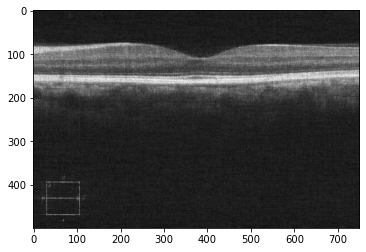

In [84]:
tau_sparse = 5
tau_low_rank = 30
a = 1
D = X*mask_3
W_c3 = np.linalg.inv(B1) @ D @ np.linalg.inv(B2t)

reconstruction_error_l1 = []
spectral_norm_l1 = []
sparsity_l1 = []

iters = 1000
for i in range(iters):
    W_c3 = Update1(mask_3, B1, B2t, W_c3, D, a)

    if i % 2 == 0:
        W_c3 = ShrinkageOperator(W_c3, tau_low_rank)
    else:
        W_c3 = SoftThresh(W_c3, tau_sparse)
    
    spectral_norm_l1.append(np.linalg.norm(W_c3, ord="nuc"))
    sparsity_l1.append(np.linalg.norm(W_c3, ord=1))
    reconstruction_error_l1.append(np.linalg.norm(X - B1 @ W_c3 @ B2t))
    if i % 50 == 0:
        print(
            f"Iteration {i+1}:\t"\
            f"Reconstruction Error: {reconstruction_error_l1[-1]:.2f}\t"\
            f"Spectral Norm W: {spectral_norm_l1[-1]:.2f}\t"\
            f"Sparisty of W: {sparsity_l1[-1]:.2f}"
        )
    if i % 250 == 0:
        print(f"Resulting Reconstruction after {i} interations:")
        plt.imshow(B1 @ W_c3 @ B2t, cmap="gray")
        display.display(plt.gcf())
        
print("\n\n Final Reconstruction")
plt.imshow(B1 @ W_c3 @ B2t, cmap="gray");

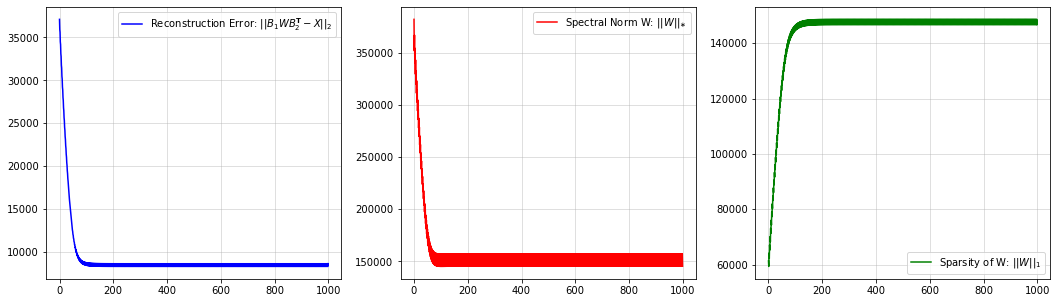

<Figure size 1008x648 with 0 Axes>

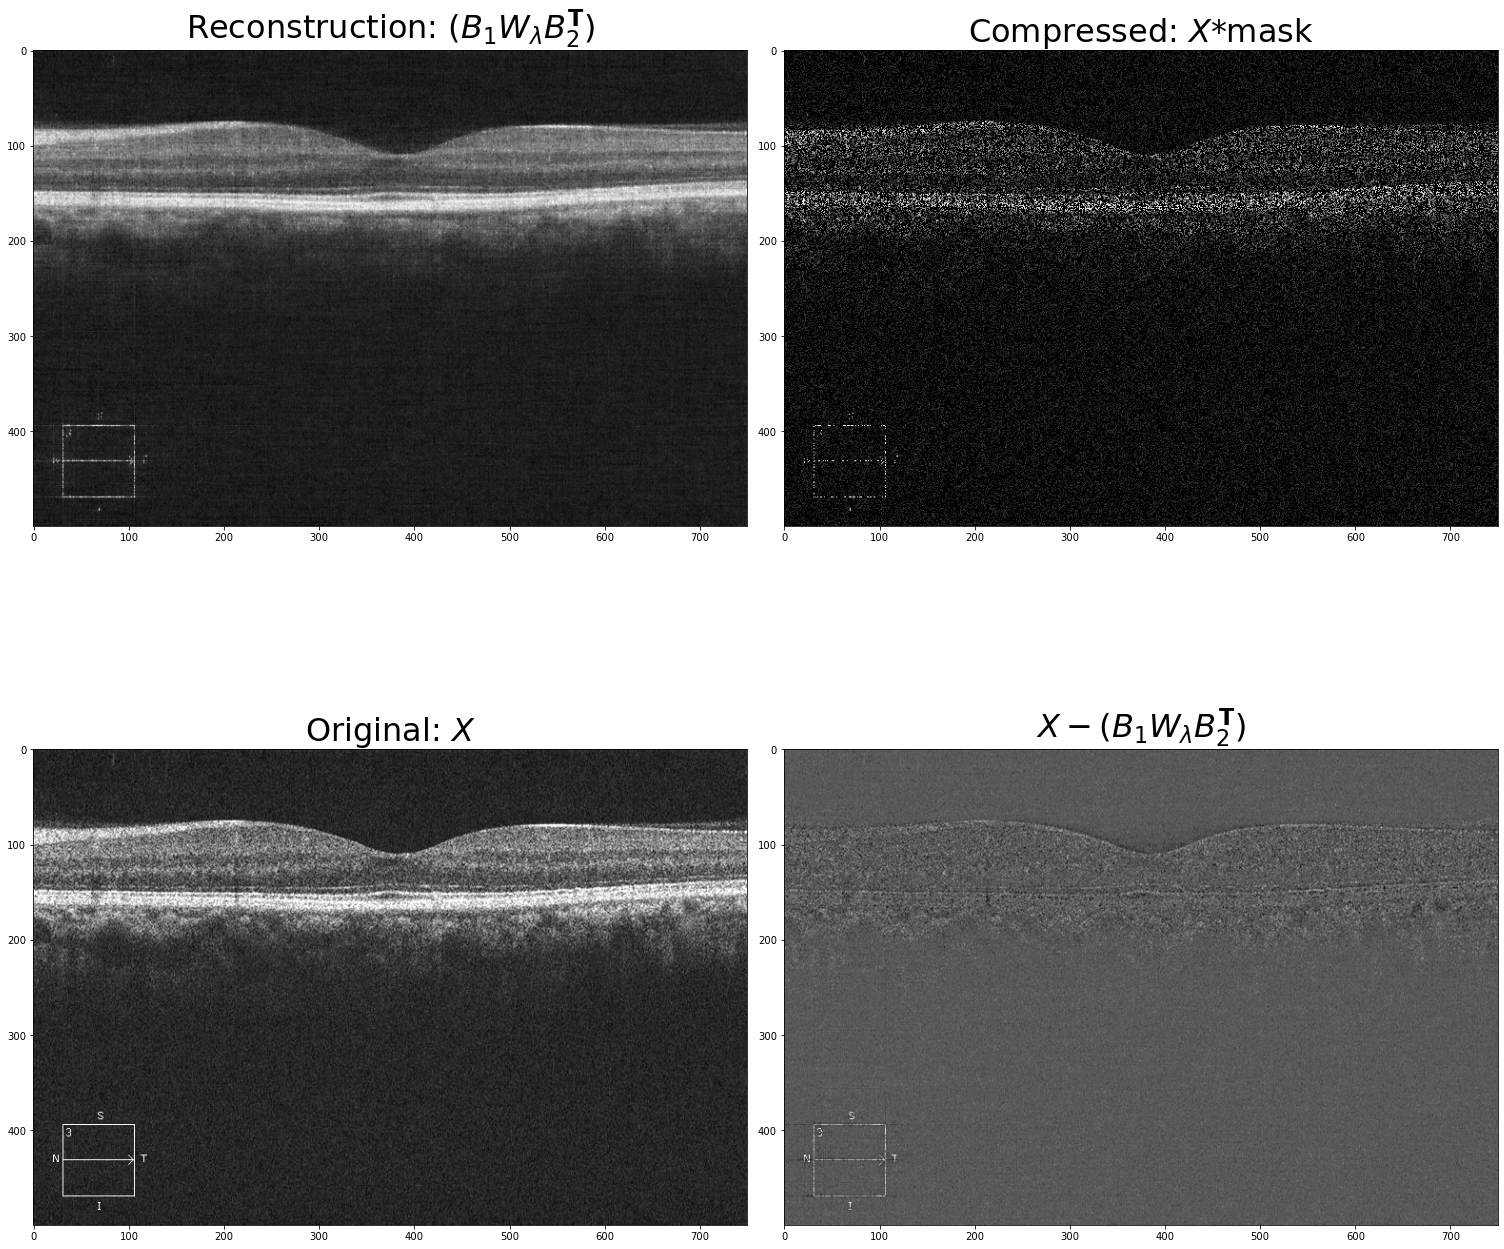

In [85]:
tau_sparse = 3
tau_low_rank = 30
fig, axes = plt.subplots(ncols=3, figsize=(18, 5))

axes[0].plot(reconstruction_error_l1, c='b', label=r"Reconstruction Error: $||B_{1} W B_{2}^{\mathbf{T}} - X ||_{2}$")
axes[1].plot(spectral_norm_l1, c='r', label=r"Spectral Norm W: $|| W ||_{\ast}$")
axes[2].plot(sparsity_l1, c='g', label=r"Sparsity of W: $|| W ||_{1}$")

axes[0].legend()
axes[1].legend()
axes[2].legend()

axes[0].grid(alpha=0.5)
axes[1].grid(alpha=0.5)
axes[2].grid(alpha=0.5)

# fig.suptitle((
#     f"Low Rank + Sparse Reconstruction using {basis_} basis " +
#     r"($\lambda_{Sparse}$ =" + f"{tau_sparse}, " +
#     r"$\lambda_{LowRank}$ =" + f"{tau_low_rank}):"),
#     fontsize=24
# )

fig.set_facecolor('white')
# plt.savefig("LowRank_Sparse_Compression_3_plots.png", dpi=400)

plt.figure(figsize=(14, 9));
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(21, 21))

axes[0][0].set_title(r"Reconstruction: $(B_{1} W_{\lambda} B_{2}^{\mathbf{T}}$)", fontsize=32)
axes[0][0].imshow(B1 @ W_c3 @ B2t, cmap="gray")

axes[0][1].set_title(r"Compressed: $X$*mask", fontsize=32)
axes[0][1].imshow(X*mask_3, cmap="gray")

axes[1][0].set_title(r"Original: $X$", fontsize=32)
axes[1][0].imshow(X, cmap="gray")

axes[1][1].set_title(r"$X - (B_{1} W_{\lambda} B_{2}^{\mathbf{T}}$)", fontsize=32)
axes[1][1].imshow(X - (B1 @ W_c3 @ B2t), cmap="gray")

plt.tight_layout()
fig.set_facecolor('white')
plt.savefig("LowRank_Sparse_Compression_3_grid.png", dpi=400)
plt.show()

# Test with degenerate Images

In [109]:
image_path = "OCTID_CSR"
image_name = "CSR25.jpeg"
image = os.path.join(image_path, image_name)

oct_image = imread(image)

# Taking the first of the 3 channels, as they are all the same.
X_deg = oct_image[:,:,0]

h, w = X_deg.shape
mask_deg = np.random.binomial(size=(h, w), n=1, p=1/compression_factor)

B1 = dct(np.eye(h), norm='ortho', axis=0).T
B2t = dct(np.eye(w), norm='ortho', axis=0)

tau_sparse = 3
tau_low_rank = 30
a = 1
D = X_deg*mask_deg

Iteration 1:	Reconstruction Error: 29402.31	Spectral Norm W: 461830.22	Sparisty of W: 53280.90
Resulting Reconstruction after 0 interations:


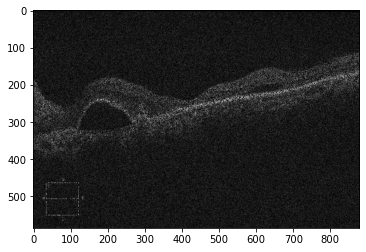

Iteration 51:	Reconstruction Error: 6556.94	Spectral Norm W: 188384.08	Sparisty of W: 85078.45
Iteration 101:	Reconstruction Error: 5290.82	Spectral Norm W: 181928.61	Sparisty of W: 90746.21
Iteration 151:	Reconstruction Error: 5264.64	Spectral Norm W: 181987.70	Sparisty of W: 91003.37
Iteration 201:	Reconstruction Error: 5262.77	Spectral Norm W: 181992.59	Sparisty of W: 91023.20
Iteration 251:	Reconstruction Error: 5262.60	Spectral Norm W: 181993.01	Sparisty of W: 91025.05
Resulting Reconstruction after 250 interations:


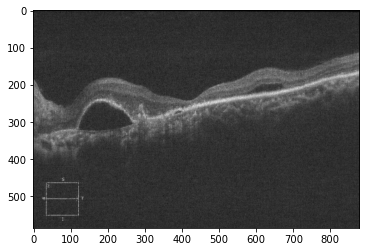

Iteration 301:	Reconstruction Error: 5262.58	Spectral Norm W: 181993.05	Sparisty of W: 91025.24
Iteration 351:	Reconstruction Error: 5262.58	Spectral Norm W: 181993.05	Sparisty of W: 91025.26
Iteration 401:	Reconstruction Error: 5262.58	Spectral Norm W: 181993.05	Sparisty of W: 91025.26
Iteration 451:	Reconstruction Error: 5262.58	Spectral Norm W: 181993.05	Sparisty of W: 91025.26
Iteration 501:	Reconstruction Error: 5262.58	Spectral Norm W: 181993.05	Sparisty of W: 91025.26
Resulting Reconstruction after 500 interations:


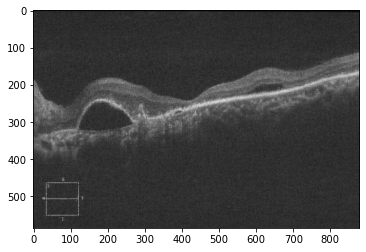

Iteration 551:	Reconstruction Error: 5262.58	Spectral Norm W: 181993.05	Sparisty of W: 91025.26
Iteration 601:	Reconstruction Error: 5262.58	Spectral Norm W: 181993.05	Sparisty of W: 91025.26
Iteration 651:	Reconstruction Error: 5262.58	Spectral Norm W: 181993.05	Sparisty of W: 91025.26
Iteration 701:	Reconstruction Error: 5262.58	Spectral Norm W: 181993.05	Sparisty of W: 91025.26
Iteration 751:	Reconstruction Error: 5262.58	Spectral Norm W: 181993.05	Sparisty of W: 91025.26
Resulting Reconstruction after 750 interations:


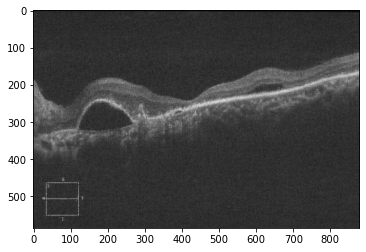

Iteration 801:	Reconstruction Error: 5262.58	Spectral Norm W: 181993.05	Sparisty of W: 91025.26
Iteration 851:	Reconstruction Error: 5262.58	Spectral Norm W: 181993.05	Sparisty of W: 91025.26
Iteration 901:	Reconstruction Error: 5262.58	Spectral Norm W: 181993.05	Sparisty of W: 91025.26
Iteration 951:	Reconstruction Error: 5262.58	Spectral Norm W: 181993.05	Sparisty of W: 91025.26


 Final Reconstruction


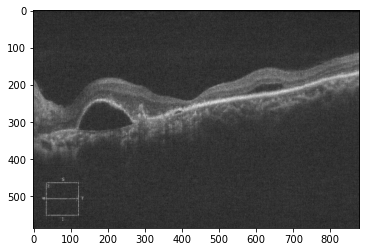

In [100]:
W_degen = np.linalg.inv(B1) @ D @ np.linalg.inv(B2t)

reconstruction_error_degen = []
spectral_norm_degen = []
sparsity_degen = []

iters = 1000
for i in range(iters):
    W_degen = Update1(mask_deg, B1, B2t, W_degen, D, a)

    if i % 2 == 0:
        W_degen = ShrinkageOperator(W_degen, tau_low_rank)
    else:
        W_degen = SoftThresh(W_degen, tau_sparse)
    
    spectral_norm_degen.append(np.linalg.norm(W_degen, ord="nuc"))
    sparsity_degen.append(np.linalg.norm(W_degen, ord=1))
    reconstruction_error_degen.append(np.linalg.norm(X_deg - B1 @ W_degen @ B2t))
    if i % 50 == 0:
        print(
            f"Iteration {i+1}:\t"\
            f"Reconstruction Error: {reconstruction_error_degen[-1]:.2f}\t"\
            f"Spectral Norm W: {spectral_norm_degen[-1]:.2f}\t"\
            f"Sparisty of W: {sparsity_degen[-1]:.2f}"
        )
    if i % 250 == 0:
        print(f"Resulting Reconstruction after {i} interations:")
        plt.imshow(B1 @ W_degen @ B2t, cmap="gray")
        display.display(plt.gcf())
        
print("\n\n Final Reconstruction")
plt.imshow(B1 @ W_degen @ B2t, cmap="gray");

In [110]:
np.sum(W_degen == 0) / (w*h)

0.5516643564087331

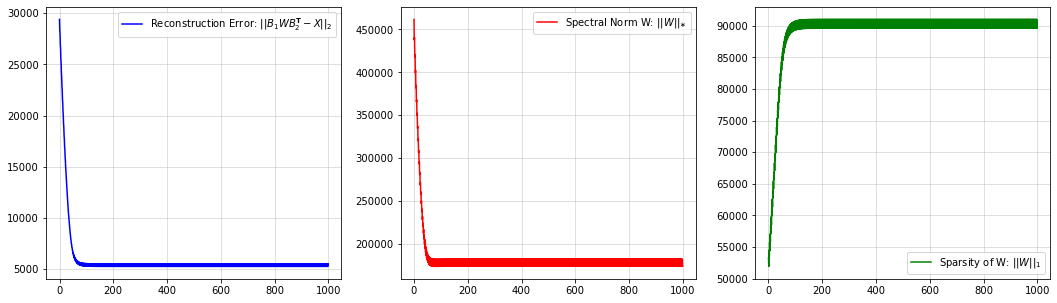

<Figure size 1008x648 with 0 Axes>

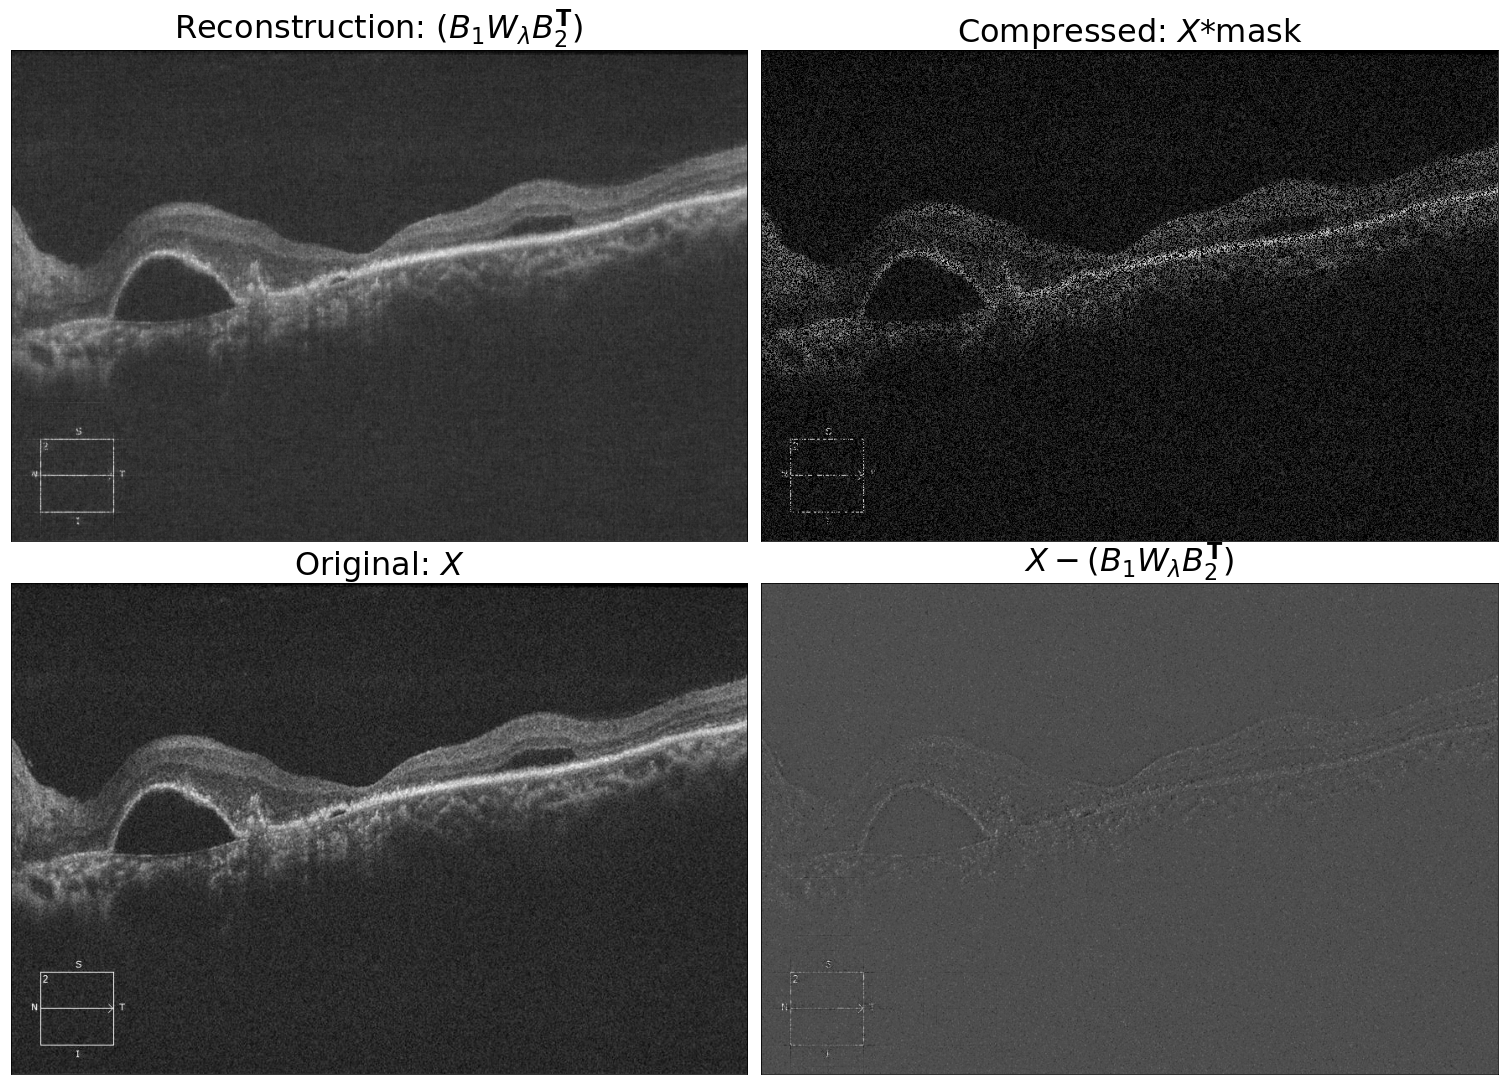

In [107]:
tau_sparse = 3
tau_low_rank = 30
fig, axes = plt.subplots(ncols=3, figsize=(18, 5))

axes[0].plot(reconstruction_error_degen, c='b', label=r"Reconstruction Error: $||B_{1} W B_{2}^{\mathbf{T}} - X ||_{2}$")
axes[1].plot(spectral_norm_degen, c='r', label=r"Spectral Norm W: $|| W ||_{\ast}$")
axes[2].plot(sparsity_degen, c='g', label=r"Sparsity of W: $|| W ||_{1}$")

axes[0].legend()
axes[1].legend()
axes[2].legend()

axes[0].grid(alpha=0.5)
axes[1].grid(alpha=0.5)
axes[2].grid(alpha=0.5)

# fig.suptitle((
#     f"Low Rank + Sparse Reconstruction using {basis_} basis " +
#     r"($\lambda_{Sparse}$ =" + f"{tau_sparse}, " +
#     r"$\lambda_{LowRank}$ =" + f"{tau_low_rank}):"),
#     fontsize=24
# )
fig.set_facecolor('white')
plt.savefig("degen_LowRank_Sparse_Compression_2_plots.png", dpi=400)
plt.show();

plt.figure(figsize=(14, 9));
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(21, 15.5))
# fig.suptitle(f"Resulting Reconstruction:", fontsize=32)

axes[0][0].set_title(r"Reconstruction: $(B_{1} W_{\lambda} B_{2}^{\mathbf{T}}$)", fontsize=32)
axes[0][0].imshow(B1 @ W_degen @ B2t, cmap="gray")

axes[0][1].set_title(r"Compressed: $X$*mask", fontsize=32)
axes[0][1].imshow(X_deg*mask_deg, cmap="gray")

axes[1][0].set_title(r"Original: $X$", fontsize=32)
axes[1][0].imshow(X_deg, cmap="gray")

axes[1][1].set_title(r"$X - (B_{1} W_{\lambda} B_{2}^{\mathbf{T}}$)", fontsize=32)
axes[1][1].imshow(X_deg - (B1 @ W_degen @ B2t), cmap="gray")

fig.tight_layout()

for ax in axes:
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    
fig.subplots_adjust(wspace=0.05, hspace=-0.1)

plt.tight_layout()
fig.set_facecolor('white')
plt.savefig("degen_LowRank_Sparse_Compression_2_grid.png", dpi=400)
plt.show()